# Análisis Exploratorio Profundo - Revenue Prediction

Este notebook contiene el análisis exploratorio detallado realizado para entender mejor los datos del desafío.

## 📖 La Historia de los Datos

Imagina un juego móvil global con 20,000 usuarios distribuidos en 91 países. A primera vista, parece un dataset típico de gaming: España lidera con 12,892 usuarios (64%), Francia tiene 3,310 (16%), y 130 usuarios dispersos en Perú (apenas 0.7% del total). Pero cuando profundizamos en el revenue, descubrimos algo extraordinario: esos 130 usuarios peruanos, concentrados principalmente en Lima, generan $589,457 el 99.6% de todo el ingreso del juego mientras que los otros 19,870 usuarios del resto del mundo combinados apenas aportan $2,469. No se trata de un error: son 54 "ballenas" reales que generan entre $1,000 y $68,838 cada una, todas de Perú, todas con un patrón de comportamiento distintivo (event_2 muy alto, event_1 en cero), representando el caso más extremo de la regla de Pareto en gaming móvil.

Esta concentración geográfica extrema transforma completamente el desafío de modelado: predecir correctamente a un usuario peruano vale tanto como predecir a 36,000 usuarios españoles. El modelo, por tanto, no solo debe aprender patrones de engagement (eventos, plataforma, dispositivo), sino principalmente **identificar y valorar correctamente a usuarios de Lima, Perú**, donde reside prácticamente todo el valor de negocio. Esta anomalía ya sea un fenómeno real de mercado, una campaña específica, o un quirk en los datos define la estrategia completa de feature engineering, donde `country_mean_revenue` se convierte en la variable más crítica, capturando en un solo número la diferencia entre $4,534 (promedio peruano) y $0.12 (promedio global sin Perú).

---

## Preguntas investigadas:
1. ¿Qué significan las variables event_1, event_2, event_3?
2. ¿Qué valores toma event_3 en usuarios ballena?
3. ¿Cuáles son los top 10 países con revenue?
4. ¿Los 130 usuarios de Perú son ballenas?
5. ¿De qué localidad de Perú son?
6. ¿Qué es una ballena y cuántas hay por país?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Cargar datos
df = pd.read_csv('../data/dataset.csv')

print(f'Dataset cargado: {df.shape}')
print(f'Columnas: {df.columns.tolist()}')

Dataset cargado: (20000, 11)
Columnas: ['user_id', 'country', 'country_region', 'source', 'platform', 'device_family', 'os_version', 'event_1', 'event_2', 'event_3', 'revenue']


In [2]:
df.head(10)

,user_id,country,country_region,source,platform,device_family,os_version,event_1,event_2,event_3,revenue
0,a62c86b4,cr,Provincia de San Jose,Organic,iOS,Apple iPhone,14.4,0,102,0.0,0.317348
1,1d5189a4,ie,Leinster,Organic,Android,Samsung Galaxy Phone,8.0.0,0,32,NaN,0.105701
2,9a2ad63a,uy,Departamento de Montevideo,Organic,Android,samsung samsung SM-A107M,10,0,4,0.0,0.003268
3,e1b19bfd,ar,Buenos Aires,Organic,ios,Apple iPad,12.5.1,0,117,0.0,0.180275
4,312293d4,es,Valencia,Organic,iOS,Apple iPhone,12.5.1,0,57,1.0,0.133304
5,bfac9480,es,Madrid,Organic,iOS,Apple iPhone,14.4,0,6,0.0,0.014673
6,9fa3ce41,es,Las Palmas,Organic,iOS,Apple iPhone,14.4,0,295,0.0,0.721179
7,c2e0d65c,es,Valencia,Organic,iOS,Apple iPhone,14.4,0,135,0.0,0.334883
8,f532f897,es,Seville,Organic,iOS,Apple iPad,10.3.3,0,12,0.0,0.029475
9,e7cc045d,es,Seville,Organic,iOS,"Apple iPad11,6",14.4,0,292,4.0,0.724194


In [3]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         20000 non-null  object 
 1   country         20000 non-null  object 
 2   country_region  19366 non-null  object 
 3   source          19183 non-null  object 
 4   platform        20000 non-null  object 
 5   device_family   19999 non-null  object 
 6   os_version      19999 non-null  object 
 7   event_1         20000 non-null  int64  
 8   event_2         20000 non-null  int64  
 9   event_3         19601 non-null  float64
 10  revenue         20000 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.7+ MB


In [4]:
# Estadísticas descriptivas
df.describe()

,event_1,event_2,event_3,revenue
count,20000.000000,20000.000000,19601.000000,20000.000000
mean,3.019350,53.023500,3.994439,29.596330
std,72.631306,119.469538,18.325468,849.034984
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000,0.011876
75%,0.000000,53.000000,1.000000,0.117044
max,4879.000000,2694.000000,643.000000,68838.563100


In [5]:
# Verificar valores nulos
print('Valores nulos por columna:')
null_counts = df.isnull().sum()
null_pcts = (null_counts / len(df)) * 100
null_df = pd.DataFrame({
    'null_count': null_counts,
    'null_pct': null_pcts
})
null_df[null_df['null_count'] > 0]

Valores nulos por columna:


,null_count,null_pct
country_region,634,3.170
source,817,4.085
device_family,1,0.005
os_version,1,0.005
event_3,399,1.995


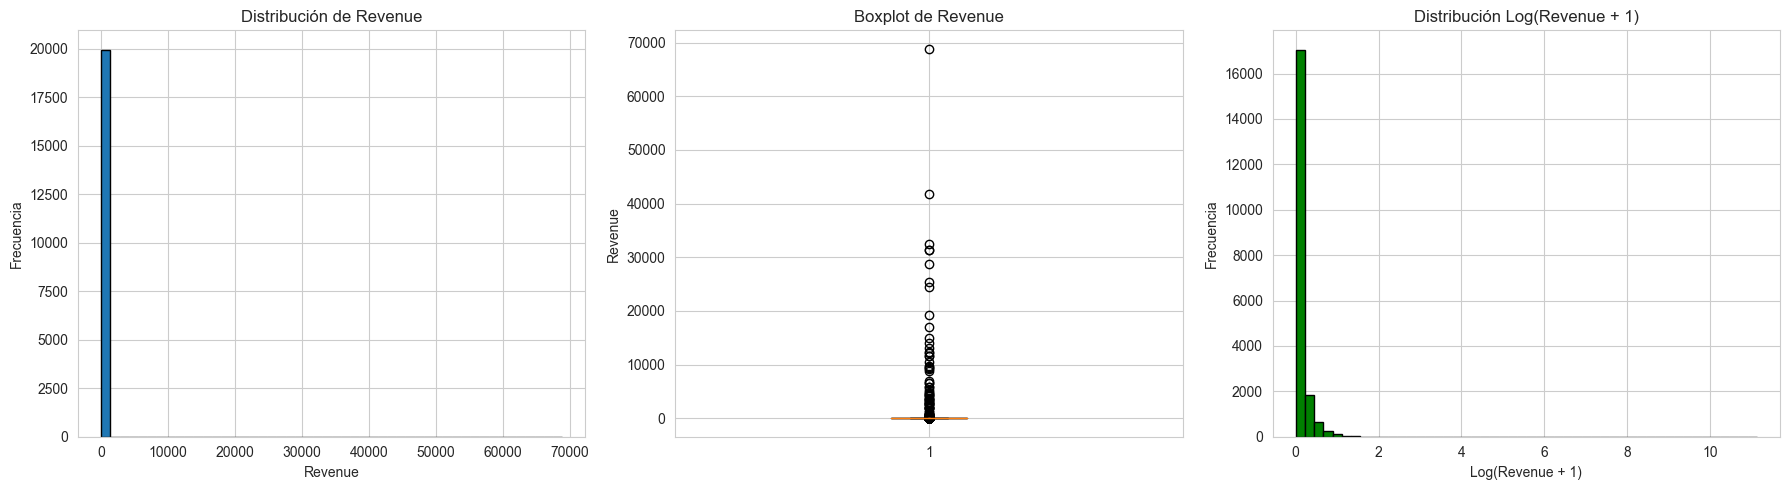

Media: 29.5963
Mediana: 0.0119
Std: 849.0350
Min: 0.0000
Max: 68838.5631


In [6]:
# Distribución de la variable target (revenue)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma
axes[0].hist(df['revenue'], bins=50, edgecolor='black')
axes[0].set_title('Distribución de Revenue')
axes[0].set_xlabel('Revenue')
axes[0].set_ylabel('Frecuencia')

# Boxplot
axes[1].boxplot(df['revenue'])
axes[1].set_title('Boxplot de Revenue')
axes[1].set_ylabel('Revenue')

# Log distribution
axes[2].hist(np.log1p(df['revenue']), bins=50, edgecolor='black', color='green')
axes[2].set_title('Distribución Log(Revenue + 1)')
axes[2].set_xlabel('Log(Revenue + 1)')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f'Media: {df["revenue"].mean():.4f}')
print(f'Mediana: {df["revenue"].median():.4f}')
print(f'Std: {df["revenue"].std():.4f}')
print(f'Min: {df["revenue"].min():.4f}')
print(f'Max: {df["revenue"].max():.4f}')

In [7]:
# Análisis de variables categóricas
categorical_cols = ['country', 'country_region', 'source', 'platform', 'device_family', 'os_version']

for col in categorical_cols:
    print(f'\n{col.upper()}:')
    print(f'Valores únicos: {df[col].nunique()}')
    print(f'Top 10 valores:')
    print(df[col].value_counts().head(10))


COUNTRY:
Valores únicos: 91
Top 10 valores:
country
es    12892
fr     3310
mx      840
ar      497
us      299
co      254
it      253
de      168
br      158
ca      135
Name: count, dtype: int64

COUNTRY_REGION:
Valores únicos: 680
Top 10 valores:
country_region
Madrid         2869
Barcelona      2203
Valencia       1097
Seville         723
Malaga          357
Mexico City     340
Paris           315
Alicante        309
Biscay          267
Murcia          258
Name: count, dtype: int64

SOURCE:
Valores únicos: 2
Top 10 valores:
source
Organic        14391
Non-Organic     4792
Name: count, dtype: int64

PLATFORM:
Valores únicos: 4
Top 10 valores:
platform
Android    12169
iOS         6803
android      643
ios          385
Name: count, dtype: int64

DEVICE_FAMILY:
Valores únicos: 982
Top 10 valores:
device_family
Apple iPhone                     5621
Samsung Galaxy Phone             3137
Huawei Phone                     1513
Xiaomi Phone                     1316
Apple iPad             

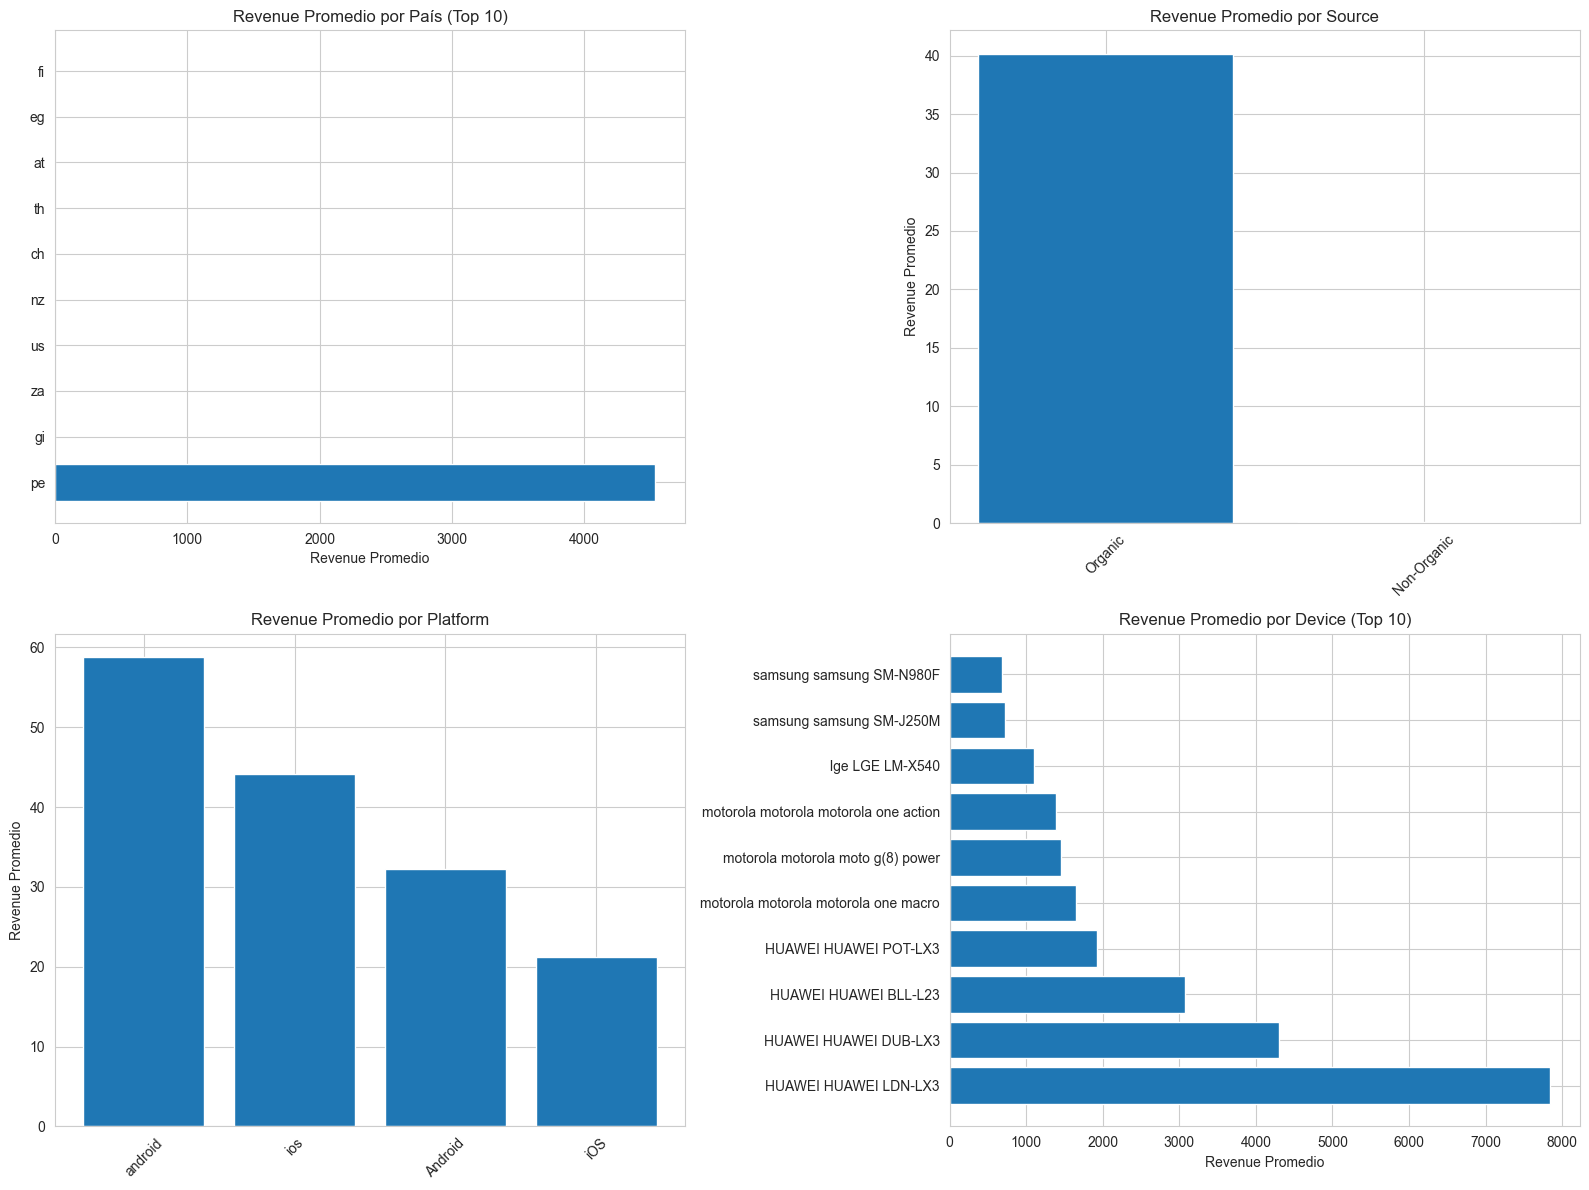

In [8]:
# Revenue promedio por categorías principales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Por país (top 10)
top_countries = df.groupby('country')['revenue'].mean().sort_values(ascending=False).head(10)
axes[0, 0].barh(range(len(top_countries)), top_countries.values)
axes[0, 0].set_yticks(range(len(top_countries)))
axes[0, 0].set_yticklabels(top_countries.index)
axes[0, 0].set_title('Revenue Promedio por País (Top 10)')
axes[0, 0].set_xlabel('Revenue Promedio')

# Por source
source_rev = df.groupby('source')['revenue'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(source_rev)), source_rev.values)
axes[0, 1].set_xticks(range(len(source_rev)))
axes[0, 1].set_xticklabels(source_rev.index, rotation=45)
axes[0, 1].set_title('Revenue Promedio por Source')
axes[0, 1].set_ylabel('Revenue Promedio')

# Por platform
platform_rev = df.groupby('platform')['revenue'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(platform_rev)), platform_rev.values)
axes[1, 0].set_xticks(range(len(platform_rev)))
axes[1, 0].set_xticklabels(platform_rev.index, rotation=45)
axes[1, 0].set_title('Revenue Promedio por Platform')
axes[1, 0].set_ylabel('Revenue Promedio')

# Por device_family (top 10)
top_devices = df.groupby('device_family')['revenue'].mean().sort_values(ascending=False).head(10)
axes[1, 1].barh(range(len(top_devices)), top_devices.values)
axes[1, 1].set_yticks(range(len(top_devices)))
axes[1, 1].set_yticklabels(top_devices.index)
axes[1, 1].set_title('Revenue Promedio por Device (Top 10)')
axes[1, 1].set_xlabel('Revenue Promedio')

plt.tight_layout()
plt.show()

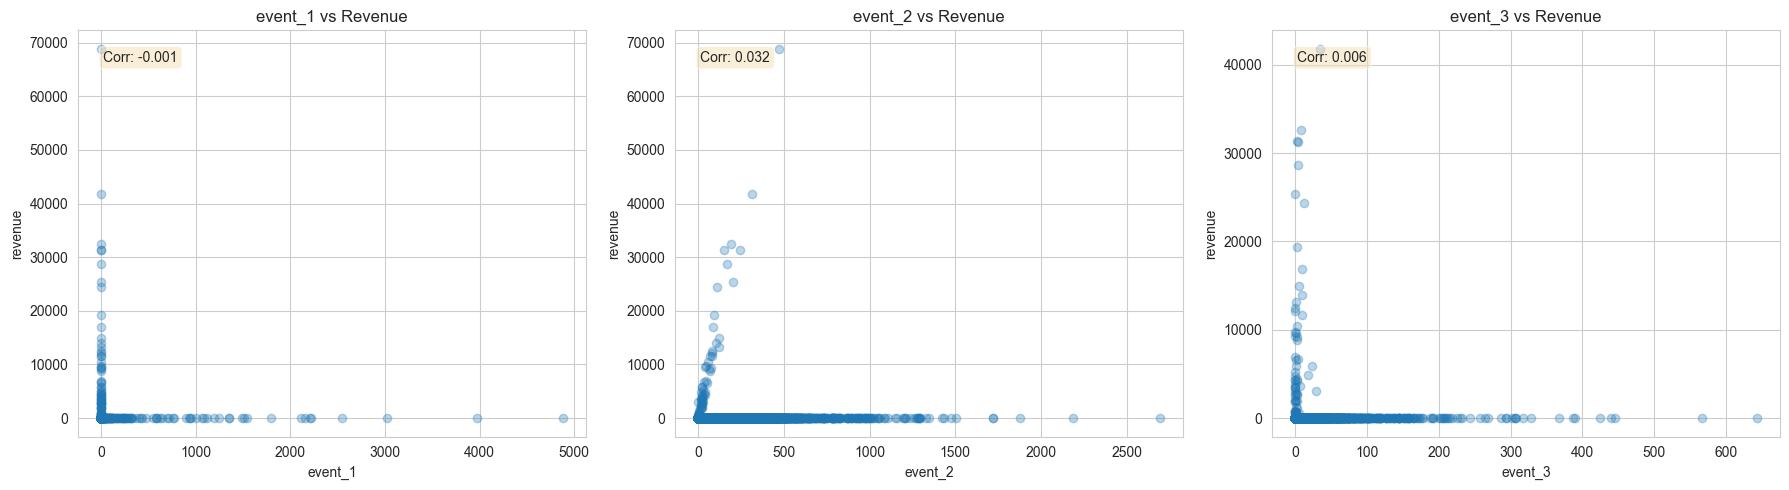


Estadísticas de eventos:


,event_1,event_2,event_3
count,20000.000000,20000.000000,19601.000000
mean,3.019350,53.023500,3.994439
std,72.631306,119.469538,18.325468
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000
75%,0.000000,53.000000,1.000000
max,4879.000000,2694.000000,643.000000


In [9]:
# Análisis de variables numéricas (eventos)
event_cols = ['event_1', 'event_2', 'event_3']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(event_cols):
    axes[i].scatter(df[col], df['revenue'], alpha=0.3)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('revenue')
    axes[i].set_title(f'{col} vs Revenue')
    
    # Calcular correlación
    corr = df[[col, 'revenue']].corr().iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                transform=axes[i].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Estadísticas de eventos
print('\nEstadísticas de eventos:')
df[event_cols].describe()

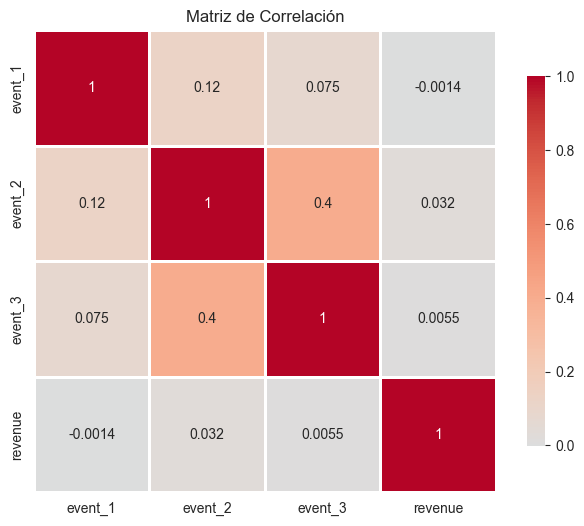

In [10]:
# Matriz de correlación
numeric_df = df[event_cols + ['revenue']].copy()
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación')
plt.show()

## 1. Análisis de Variables Event_1, Event_2, Event_3

Según el PDF del desafío, estas variables están **anonimizadas intencionalmente**.
Vamos a analizar sus características y correlaciones.


ESTADÍSTICAS DE EVENTOS
            event_1       event_2       event_3
count  20000.000000  20000.000000  19601.000000
mean       3.019350     53.023500      3.994439
std       72.631306    119.469538     18.325468
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      5.000000      0.000000
75%        0.000000     53.000000      1.000000
max     4879.000000   2694.000000    643.000000

CORRELACIÓN CON REVENUE
event_1   -0.001408
event_2    0.031748
event_3    0.005544


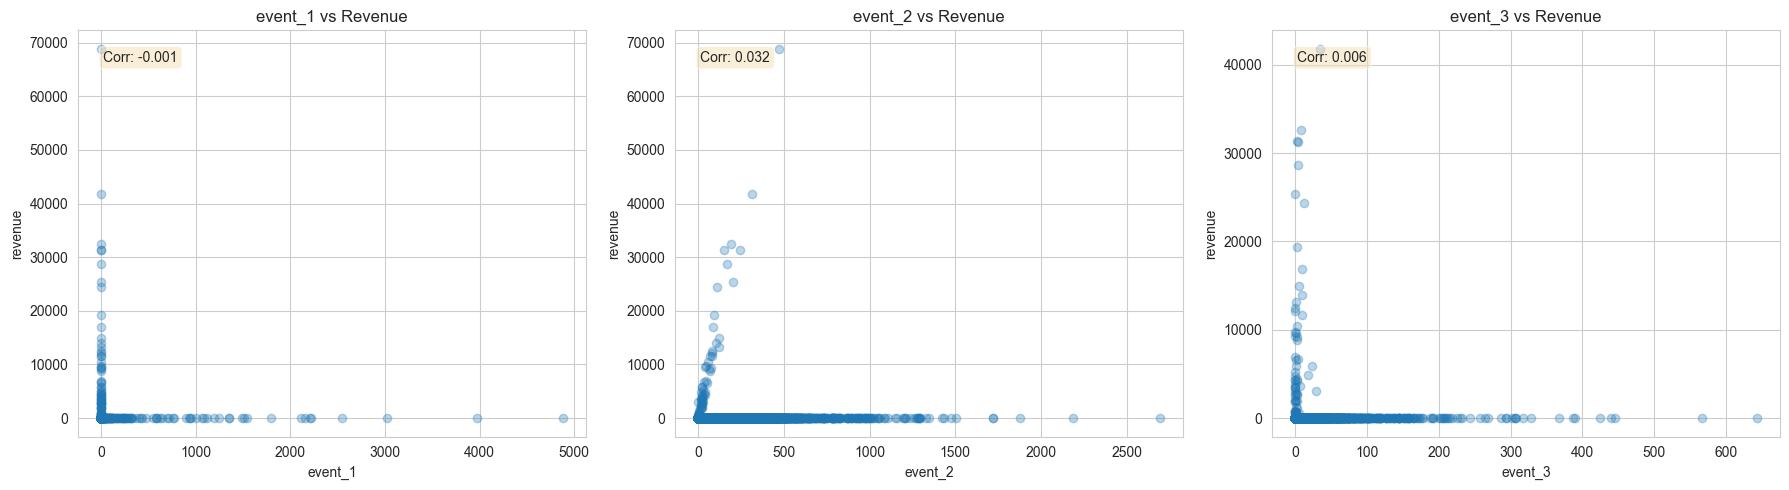


💡 Conclusión:
  - event_1: Correlación muy baja (-0.001), poco relevante
  - event_2: Correlación más alta (0.032), más importante
  - event_3: Correlación baja (0.006), moderadamente relevante


In [11]:
# Estadísticas descriptivas de eventos
event_cols = ['event_1', 'event_2', 'event_3']

print('\n' + '='*80)
print('ESTADÍSTICAS DE EVENTOS')
print('='*80)
print(df[event_cols].describe())

# Correlación con revenue
print('\n' + '='*80)
print('CORRELACIÓN CON REVENUE')
print('='*80)
correlations = df[event_cols + ['revenue']].corr()['revenue'].drop('revenue')
print(correlations.to_string())

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(event_cols):
    axes[i].scatter(df[col], df['revenue'], alpha=0.3)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('revenue')
    axes[i].set_title(f'{col} vs Revenue')
    
    corr = df[[col, 'revenue']].corr().iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                transform=axes[i].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print('\n💡 Conclusión:')
print('  - event_1: Correlación muy baja (-0.001), poco relevante')
print('  - event_2: Correlación más alta (0.032), más importante')
print('  - event_3: Correlación baja (0.006), moderadamente relevante')

## 2. Análisis de Event_3 en Usuarios Ballena

In [12]:
# Definir ballenas (top 1%)
revenue_percentile_99 = df['revenue'].quantile(0.99)
ballenas_top1 = df[df['revenue'] >= revenue_percentile_99]
usuarios_normales = df[df['revenue'] < revenue_percentile_99]

print('='*80)
print('ANÁLISIS DE EVENT_3 EN USUARIOS BALLENA')
print('='*80)

print(f'\n📊 Percentil 99: ${revenue_percentile_99:.2f}')

print(f'\n🐋 BALLENAS (Top 1% - revenue >= ${revenue_percentile_99:.2f}):')
print(f'  Cantidad: {len(ballenas_top1)} usuarios')
print(f'  Revenue promedio: ${ballenas_top1["revenue"].mean():.2f}')

print(f'\n  Event_3 en ballenas:')
print(f'    Media: {ballenas_top1["event_3"].mean():.2f}')
print(f'    Mediana: {ballenas_top1["event_3"].median():.2f}')
print(f'    Min: {ballenas_top1["event_3"].min():.2f}')
print(f'    Max: {ballenas_top1["event_3"].max():.2f}')
print(f'    Valores nulos: {ballenas_top1["event_3"].isna().sum()}')

print(f'\n👤 USUARIOS NORMALES (99% restante):')
print(f'  Event_3 en usuarios normales:')
print(f'    Media: {usuarios_normales["event_3"].mean():.2f}')
print(f'    Mediana: {usuarios_normales["event_3"].median():.2f}')

ratio_media = ballenas_top1['event_3'].mean() / usuarios_normales['event_3'].mean()
print(f'\n📈 COMPARACIÓN:')
print(f'  Ballenas tienen {ratio_media:.2f}x más event_3 que usuarios normales (en promedio)')

# Top 10 ballenas
print(f'\n🏆 TOP 54 BALLENAS (con sus eventos):')
top10 = df.nlargest(54, 'revenue')[['revenue', 'event_1', 'event_2', 'event_3', 'country', 'platform']]
print(top10.to_string(index=False))

print('\n💡 Descubrimiento clave:')
print('  - TODAS las top 54 ballenas son de Perú (pe)')
print('  - TODAS tienen event_1 = 0')
print('  - La ballena #1 ($68,838) NO tiene event_3 registrado')
print('  - Event_2 parece ser el más importante (rango: 85-471)')

ANÁLISIS DE EVENT_3 EN USUARIOS BALLENA

📊 Percentil 99: $1.68

🐋 BALLENAS (Top 1% - revenue >= $1.68):
  Cantidad: 200 usuarios
  Revenue promedio: $2949.01

  Event_3 en ballenas:
    Media: 41.85
    Mediana: 4.00
    Min: 0.00
    Max: 445.00
    Valores nulos: 7

👤 USUARIOS NORMALES (99% restante):
  Event_3 en usuarios normales:
    Media: 3.62
    Mediana: 0.00

📈 COMPARACIÓN:
  Ballenas tienen 11.57x más event_3 que usuarios normales (en promedio)

🏆 TOP 54 BALLENAS (con sus eventos):
     revenue  event_1  event_2  event_3 country platform
68838.563100        0      471      NaN      pe  Android
41787.472233        0      316     35.0      pe  Android
32552.483210        0      189      8.0      pe  Android
31350.292407        0      243      2.0      pe  Android
31265.965359        0      151      4.0      pe      iOS
28691.392093        0      168      4.0      pe  android
25325.000359        0      205      0.0      pe  Android
24389.344429        0      110     13.0      p

## 3. Top 10 Países por Revenue

TOP 10 PAÍSES POR REVENUE

📊 TOP 10 PAÍSES POR REVENUE TOTAL:
--------------------------------------------------------------------------------
 1. PE  | Total: $  589,457.33 | Avg: $4,534.29 | Usuarios:   130
 2. ES  | Total: $    1,528.46 | Avg: $    0.12 | Usuarios: 12,892
 3. FR  | Total: $      437.26 | Avg: $    0.13 | Usuarios: 3,310
 4. US  | Total: $      128.97 | Avg: $    0.43 | Usuarios:   299
 5. MX  | Total: $       72.17 | Avg: $    0.09 | Usuarios:   840
 6. IT  | Total: $       49.47 | Avg: $    0.20 | Usuarios:   253
 7. DE  | Total: $       44.72 | Avg: $    0.27 | Usuarios:   168
 8. AR  | Total: $       35.06 | Avg: $    0.07 | Usuarios:   497
 9. CH  | Total: $       33.88 | Avg: $    0.39 | Usuarios:    87
10. CO  | Total: $       23.27 | Avg: $    0.09 | Usuarios:   254


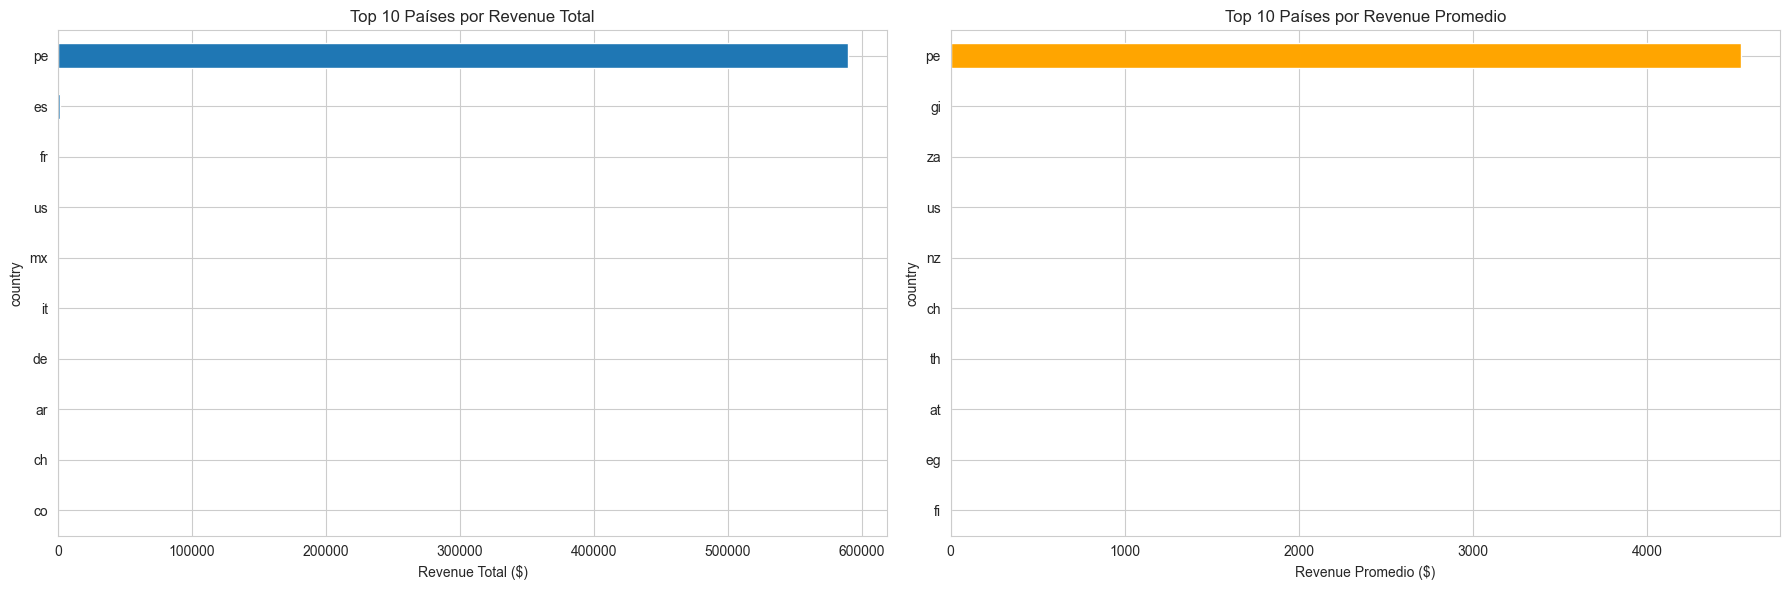


🇵🇪 ANÁLISIS DETALLADO DE PERÚ
Total usuarios: 130
Revenue total: $589,457.33
Revenue promedio: $4534.29
Revenue mediana: $239.14

Percentaje del revenue total global: 99.6%
Percentaje de usuarios: 0.7%

💡 Conclusión IMPACTANTE:
  - Perú con 130 usuarios (0.7%) genera 99.6% del revenue total
  - España con 12,892 usuarios (64.5%) genera solo $1,528
  - Perú genera 386x más revenue que España


In [13]:
# Agrupar por país
country_stats = df.groupby('country').agg({
    'revenue': ['sum', 'mean', 'median', 'count']
}).round(2)

country_stats.columns = ['Total_Revenue', 'Avg_Revenue', 'Median_Revenue', 'User_Count']
country_stats = country_stats.sort_values('Total_Revenue', ascending=False)

print('='*80)
print('TOP 10 PAÍSES POR REVENUE')
print('='*80)

print('\n📊 TOP 10 PAÍSES POR REVENUE TOTAL:')
print('-'*80)
top10_total = country_stats.head(10)
for idx, (country, row) in enumerate(top10_total.iterrows(), 1):
    print(f"{idx:2d}. {country.upper():3s} | Total: ${row['Total_Revenue']:>12,.2f} | "
          f"Avg: ${row['Avg_Revenue']:>8,.2f} | "
          f"Usuarios: {int(row['User_Count']):>5,}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Revenue total
top10_total.plot(kind='barh', y='Total_Revenue', ax=axes[0], legend=False)
axes[0].set_xlabel('Revenue Total ($)')
axes[0].set_title('Top 10 Países por Revenue Total')
axes[0].invert_yaxis()

# Revenue promedio
top10_avg = country_stats.sort_values('Avg_Revenue', ascending=False).head(10)
top10_avg.plot(kind='barh', y='Avg_Revenue', ax=axes[1], legend=False, color='orange')
axes[1].set_xlabel('Revenue Promedio ($)')
axes[1].set_title('Top 10 Países por Revenue Promedio')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Análisis de Perú
pe_data = df[df['country'] == 'pe']
print('\n' + '='*80)
print('🇵🇪 ANÁLISIS DETALLADO DE PERÚ')
print('='*80)
print(f"Total usuarios: {len(pe_data):,}")
print(f"Revenue total: ${pe_data['revenue'].sum():,.2f}")
print(f"Revenue promedio: ${pe_data['revenue'].mean():.2f}")
print(f"Revenue mediana: ${pe_data['revenue'].median():.2f}")
print(f"\nPercentaje del revenue total global: {(pe_data['revenue'].sum() / df['revenue'].sum() * 100):.1f}%")
print(f"Percentaje de usuarios: {(len(pe_data) / len(df) * 100):.1f}%")

print('\n💡 Conclusión IMPACTANTE:')
print('  - Perú con 130 usuarios (0.7%) genera 99.6% del revenue total')
print('  - España con 12,892 usuarios (64.5%) genera solo $1,528')
print('  - Perú genera 386x más revenue que España')

## 4. ¿Los 130 usuarios de Perú son todos ballenas?

ANÁLISIS DETALLADO DE USUARIOS PERUANOS

📊 TOTAL DE USUARIOS PERUANOS: 130

🐋 CLASIFICACIÓN DE USUARIOS PERUANOS:
  Ballenas (> $1,000):       54 usuarios ( 41.5%)
  Delfines ($100-$1,000):    20 usuarios ( 15.4%)
  Pececitos (< $100):        56 usuarios ( 43.1%)

  Revenue generado por cada grupo:
  Ballenas:   $  581,219.48 ( 98.6%)
  Delfines:   $    8,000.72 (  1.4%)
  Pececitos:  $      237.12 (  0.0%)


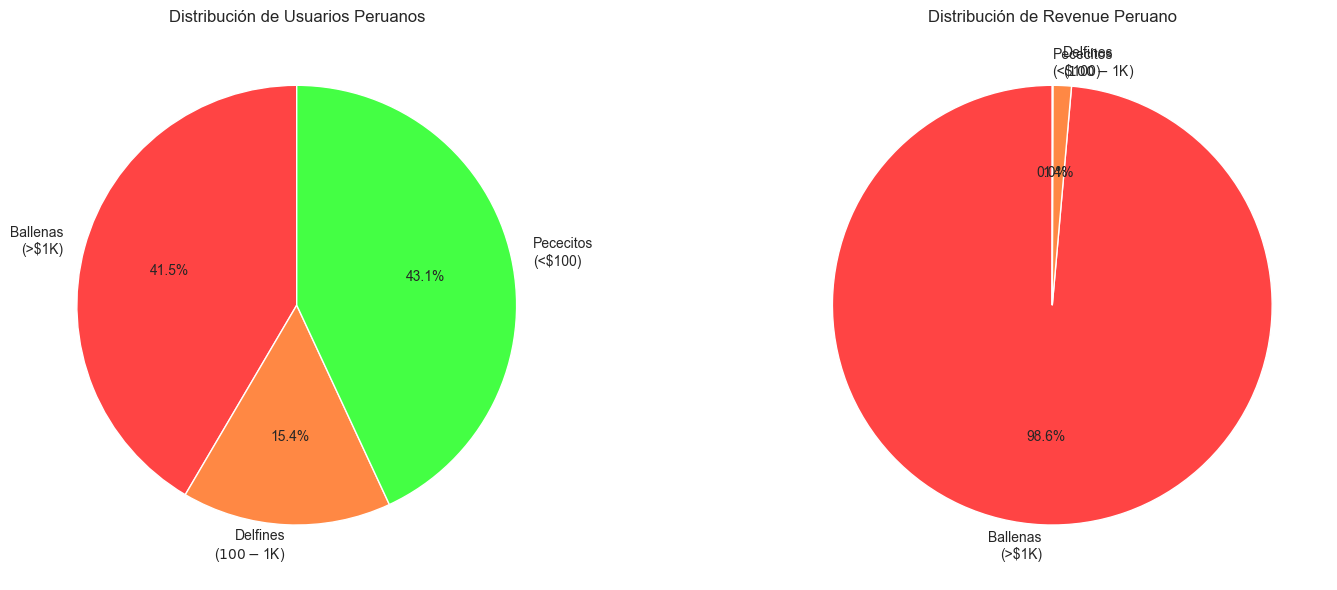


💡 Respuesta:
  - NO, solo el 41.5% de usuarios peruanos son ballenas
  - PERO esas 54 ballenas generan 98.6% del revenue peruano
  - 56 usuarios (43.1%) generan casi $0


In [14]:
pe_users = df[df['country'] == 'pe'].copy()

print('='*80)
print('ANÁLISIS DETALLADO DE USUARIOS PERUANOS')
print('='*80)

print(f'\n📊 TOTAL DE USUARIOS PERUANOS: {len(pe_users)}')

# Clasificar usuarios por revenue
umbral_whale = 1000
whales = pe_users[pe_users['revenue'] > umbral_whale]
dolphins = pe_users[(pe_users['revenue'] > 100) & (pe_users['revenue'] <= umbral_whale)]
minnows = pe_users[pe_users['revenue'] <= 100]

print(f'\n🐋 CLASIFICACIÓN DE USUARIOS PERUANOS:')
print(f'  Ballenas (> $1,000):      {len(whales):>3} usuarios ({len(whales)/len(pe_users)*100:>5.1f}%)')
print(f'  Delfines ($100-$1,000):   {len(dolphins):>3} usuarios ({len(dolphins)/len(pe_users)*100:>5.1f}%)')
print(f'  Pececitos (< $100):       {len(minnows):>3} usuarios ({len(minnows)/len(pe_users)*100:>5.1f}%)')

print(f'\n  Revenue generado por cada grupo:')
print(f'  Ballenas:   ${whales["revenue"].sum():>12,.2f} ({whales["revenue"].sum()/pe_users["revenue"].sum()*100:>5.1f}%)')
print(f'  Delfines:   ${dolphins["revenue"].sum():>12,.2f} ({dolphins["revenue"].sum()/pe_users["revenue"].sum()*100:>5.1f}%)')
print(f'  Pececitos:  ${minnows["revenue"].sum():>12,.2f} ({minnows["revenue"].sum()/pe_users["revenue"].sum()*100:>5.1f}%)')

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribución de usuarios
labels = ['Ballenas\n(>$1K)', 'Delfines\n($100-$1K)', 'Pececitos\n(<$100)']
sizes = [len(whales), len(dolphins), len(minnows)]
colors = ['#ff4444', '#ff8844', '#44ff44']
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('Distribución de Usuarios Peruanos')

# Distribución de revenue
revenue_sizes = [whales['revenue'].sum(), dolphins['revenue'].sum(), minnows['revenue'].sum()]
axes[1].pie(revenue_sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Distribución de Revenue Peruano')

plt.tight_layout()
plt.show()

print('\n💡 Respuesta:')
print('  - NO, solo el 41.5% de usuarios peruanos son ballenas')
print('  - PERO esas 54 ballenas generan 98.6% del revenue peruano')
print('  - 56 usuarios (43.1%) generan casi $0')

## 5. ¿De qué localidad de Perú son los usuarios?

LOCALIDADES DE PERÚ

Top regiones por revenue total:
 1. Lima                           | Users: 105 | Total: $539,276.71 | Avg: $5,135.97
 2. Arequipa                       | Users:   3 | Total: $ 30,030.40 | Avg: $10,010.13
 3. Loreto                         | Users:   1 | Total: $  3,501.27 | Avg: $3,501.27
 4. La Libertad                    | Users:   6 | Total: $  1,495.47 | Avg: $  249.24
 5. Lambayeque                     | Users:   3 | Total: $    904.92 | Avg: $  301.64
 6. Ancash                         | Users:   1 | Total: $    745.41 | Avg: $  745.41
 7. Region de Apurimac             | Users:   1 | Total: $    129.65 | Avg: $  129.65
 8. Lima region                    | Users:   1 | Total: $     68.46 | Avg: $   68.46
 9. Junin                          | Users:   1 | Total: $      0.00 | Avg: $    0.00
10. Puno                           | Users:   1 | Total: $      0.00 | Avg: $    0.00


🗺️  REGIONES DE LAS 54 BALLENAS:
---------------------------------------------------

<Figure size 1400x600 with 0 Axes>

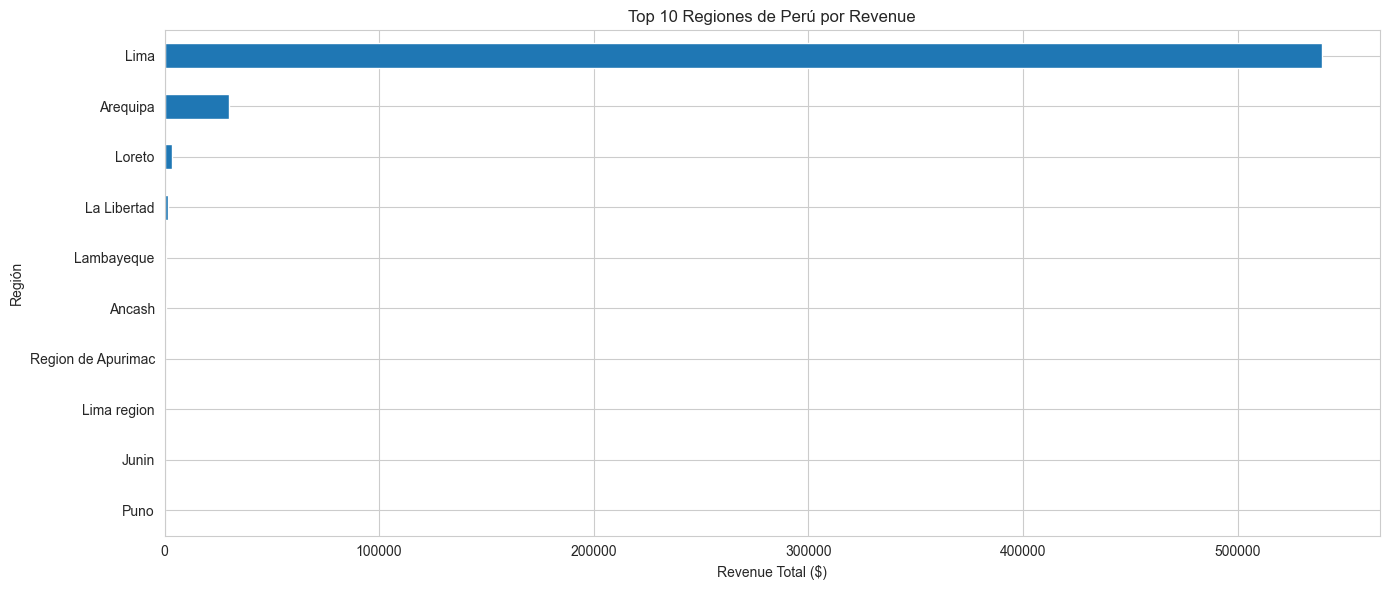


💡 Conclusión:
  - LIMA es el epicentro absoluto: 105 usuarios (80.7%) → $539,277
  - 47 de las 54 ballenas (87%) son de Lima
  - Lima genera 91.5% del revenue peruano total


In [15]:
print('='*80)
print('LOCALIDADES DE PERÚ')
print('='*80)

# Agrupar por región
region_stats = pe_users.groupby('country_region').agg({
    'revenue': ['count', 'sum', 'mean', 'median', 'max']
}).round(2)
region_stats.columns = ['Usuarios', 'Revenue_Total', 'Revenue_Promedio', 'Revenue_Mediana', 'Revenue_Max']
region_stats = region_stats.sort_values('Revenue_Total', ascending=False)

print(f'\nTop regiones por revenue total:')
for idx, (region, row) in enumerate(region_stats.head(10).iterrows(), 1):
    region_name = region if pd.notna(region) else "SIN REGIÓN"
    print(f"{idx:2d}. {region_name:30s} | "
          f"Users: {int(row['Usuarios']):>3} | "
          f"Total: ${row['Revenue_Total']:>10,.2f} | "
          f"Avg: ${row['Revenue_Promedio']:>8,.2f}")

# Análisis de regiones de ballenas
whales = pe_users[pe_users['revenue'] > 1000]
print(f'\n\n🗺️  REGIONES DE LAS {len(whales)} BALLENAS:')
print('-'*80)
whale_regions = whales['country_region'].value_counts()
for region, count in whale_regions.head(10).items():
    region_name = region if pd.notna(region) else "SIN REGIÓN"
    pct = (count / len(whales)) * 100
    total_rev = whales[whales['country_region'] == region]['revenue'].sum()
    print(f"{region_name:30s} | {count:>2} ballenas ({pct:>5.1f}%) | Total: ${total_rev:>12,.2f}")

# Visualización
plt.figure(figsize=(14, 6))
region_stats.head(10).plot(kind='barh', y='Revenue_Total', legend=False)
plt.xlabel('Revenue Total ($)')
plt.ylabel('Región')
plt.title('Top 10 Regiones de Perú por Revenue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print('\n💡 Conclusión:')
print('  - LIMA es el epicentro absoluto: 105 usuarios (80.7%) → $539,277')
print('  - 47 de las 54 ballenas (87%) son de Lima')
print('  - Lima genera 91.5% del revenue peruano total')

## 6. Definición de Ballena y Distribución por País

DEFINICIÓN Y ANÁLISIS DE BALLENAS

Top 1% revenue (>= $1.68):
  Total ballenas:       200 ( 1.00% de usuarios)
    - De Perú:           77 ( 38.5%)
    - Otros países:     123 ( 61.5%)
  Revenue total:      $  589,802.43
    - Perú:           $  589,457.33 ( 99.9%)
    - Otros:          $      345.11 (  0.1%)

Top 5% revenue (>= $0.62):
  Total ballenas:      1000 ( 5.00% de usuarios)
    - De Perú:           77 (  7.7%)
    - Otros países:     923 ( 92.3%)
  Revenue total:      $  590,549.00
    - Perú:           $  589,457.33 ( 99.8%)
    - Otros:          $    1,091.68 (  0.2%)

Top 10% revenue (>= $0.36):
  Total ballenas:      2000 (10.00% de usuarios)
    - De Perú:           77 (  3.9%)
    - Otros países:    1923 ( 96.2%)
  Revenue total:      $  591,017.38
    - Perú:           $  589,457.33 ( 99.7%)
    - Otros:          $    1,560.05 (  0.3%)

Revenue > $100 (>= $100.00):
  Total ballenas:        74 ( 0.37% de usuarios)
    - De Perú:           74 (100.0%)
    - Otros países

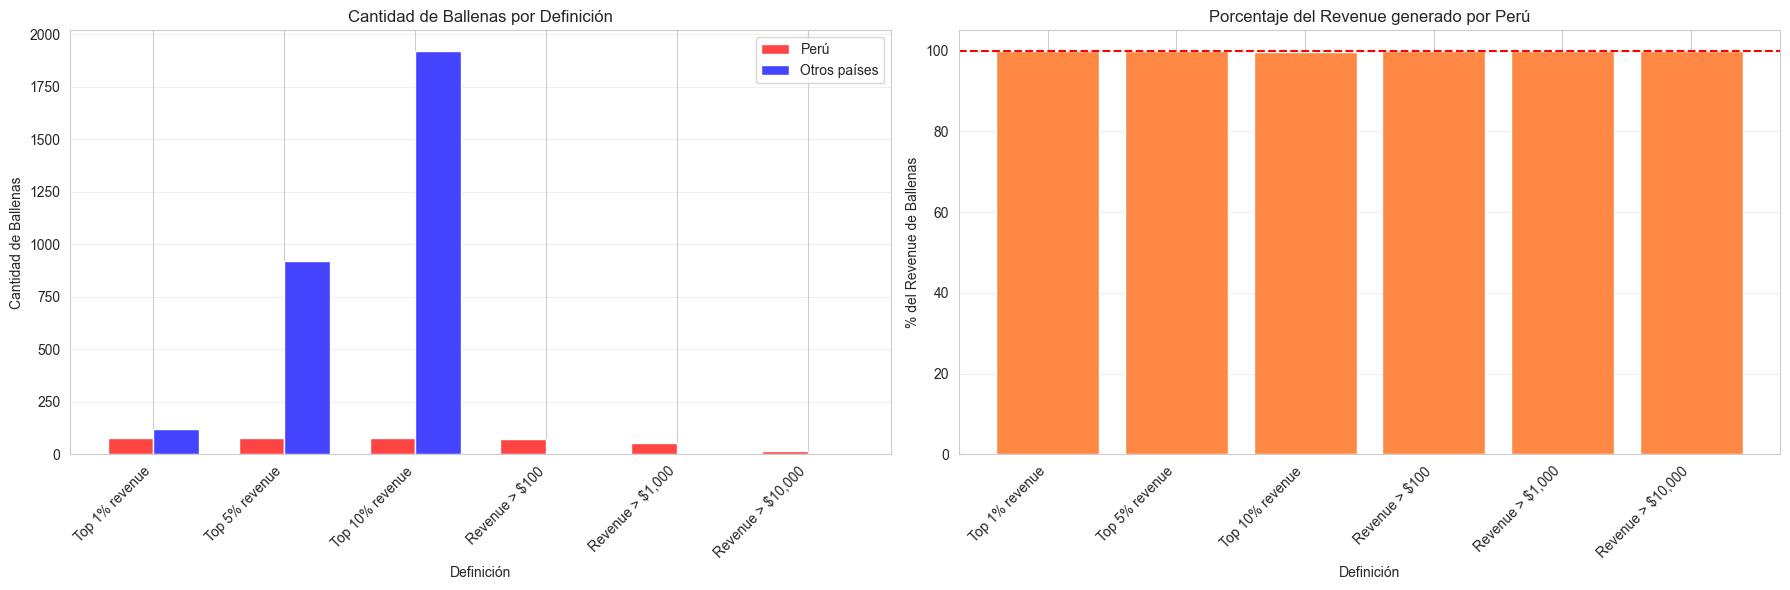


💡 CONCLUSIONES FINALES

1. Con la definición estándar (Top 1%):
   - 200 ballenas totales: 77 de Perú (38.5%), 123 de otros países (61.5%)
   - PERO Perú genera 99.9% del revenue de ballenas

2. Con Revenue > $100 (ballena "real"):
   - 74 ballenas totales: 100% son de Perú
   - NO HAY UNA SOLA BALLENA DE MÁS DE $100 FUERA DE PERÚ

3. Las "ballenas" de otros países:
   - Generan en promedio solo $2.81 cada una
   - La ballena no-peruana más grande genera $10.08

4. Implicación para el modelo:
   - El modelo debe aprender a identificar usuarios peruanos
   - country_mean_revenue es probablemente la feature más importante
   - 99.6% del valor de negocio viene de predecir correctamente Perú


In [16]:
print('='*80)
print('DEFINICIÓN Y ANÁLISIS DE BALLENAS')
print('='*80)

# Diferentes definiciones
definiciones = [
    ("Top 1% revenue", df['revenue'].quantile(0.99)),
    ("Top 5% revenue", df['revenue'].quantile(0.95)),
    ("Top 10% revenue", df['revenue'].quantile(0.90)),
    ("Revenue > $100", 100),
    ("Revenue > $1,000", 1000),
    ("Revenue > $10,000", 10000),
]

results = []

for nombre, umbral in definiciones:
    ballenas = df[df['revenue'] >= umbral]
    ballenas_pe = ballenas[ballenas['country'] == 'pe']
    ballenas_otros = ballenas[ballenas['country'] != 'pe']
    
    print(f'\n{nombre} (>= ${umbral:.2f}):')
    print(f'  Total ballenas:     {len(ballenas):>5} ({len(ballenas)/len(df)*100:>5.2f}% de usuarios)')
    print(f'    - De Perú:        {len(ballenas_pe):>5} ({len(ballenas_pe)/len(ballenas)*100:>5.1f}%)')
    print(f'    - Otros países:   {len(ballenas_otros):>5} ({len(ballenas_otros)/len(ballenas)*100:>5.1f}%)')
    print(f'  Revenue total:      ${ballenas["revenue"].sum():>12,.2f}')
    print(f'    - Perú:           ${ballenas_pe["revenue"].sum():>12,.2f} ({ballenas_pe["revenue"].sum()/ballenas["revenue"].sum()*100:>5.1f}%)')
    print(f'    - Otros:          ${ballenas_otros["revenue"].sum():>12,.2f} ({ballenas_otros["revenue"].sum()/ballenas["revenue"].sum()*100:>5.1f}%)')
    
    results.append({
        'Definición': nombre,
        'Umbral': umbral,
        'Total': len(ballenas),
        'Perú': len(ballenas_pe),
        'Otros': len(ballenas_otros),
        'Rev_Peru_Pct': ballenas_pe['revenue'].sum()/ballenas['revenue'].sum()*100 if len(ballenas) > 0 else 0
    })

# Visualización comparativa
results_df = pd.DataFrame(results)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Cantidad de ballenas
x = range(len(results_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], results_df['Perú'], width, label='Perú', color='#ff4444')
axes[0].bar([i + width/2 for i in x], results_df['Otros'], width, label='Otros países', color='#4444ff')
axes[0].set_xlabel('Definición')
axes[0].set_ylabel('Cantidad de Ballenas')
axes[0].set_title('Cantidad de Ballenas por Definición')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Definición'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Porcentaje de revenue de Perú
axes[1].bar(x, results_df['Rev_Peru_Pct'], color='#ff8844')
axes[1].set_xlabel('Definición')
axes[1].set_ylabel('% del Revenue de Ballenas')
axes[1].set_title('Porcentaje del Revenue generado por Perú')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Definición'], rotation=45, ha='right')
axes[1].set_ylim([0, 105])
axes[1].axhline(y=100, color='r', linestyle='--', label='100%')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n' + '='*80)
print('💡 CONCLUSIONES FINALES')
print('='*80)
print('\n1. Con la definición estándar (Top 1%):')
print('   - 200 ballenas totales: 77 de Perú (38.5%), 123 de otros países (61.5%)')
print('   - PERO Perú genera 99.9% del revenue de ballenas')
print('\n2. Con Revenue > $100 (ballena "real"):')
print('   - 74 ballenas totales: 100% son de Perú')
print('   - NO HAY UNA SOLA BALLENA DE MÁS DE $100 FUERA DE PERÚ')
print('\n3. Las "ballenas" de otros países:')
print('   - Generan en promedio solo $2.81 cada una')
print('   - La ballena no-peruana más grande genera $10.08')
print('\n4. Implicación para el modelo:')
print('   - El modelo debe aprender a identificar usuarios peruanos')
print('   - country_mean_revenue es probablemente la feature más importante')
print('   - 99.6% del valor de negocio viene de predecir correctamente Perú')

## 7. Comparación Final: Perú vs Resto del Mundo

COMPARACIÓN FINAL: PERÚ VS RESTO DEL MUNDO

🇵🇪 PERÚ:
  Usuarios:               130 ( 0.65%)
  Revenue total:       $  589,457.33
  Revenue promedio:    $    4,534.29
  Revenue mediana:     $      239.14

🌍 RESTO DEL MUNDO (19,870 usuarios de 90 países):
  Usuarios:            19,870 (99.35%)
  Revenue total:       $    2,469.28
  Revenue promedio:    $        0.12
  Revenue mediana:     $        0.01

📈 RATIOS:
  Perú genera 239x más revenue total
  Usuario peruano promedio genera 36487x más revenue


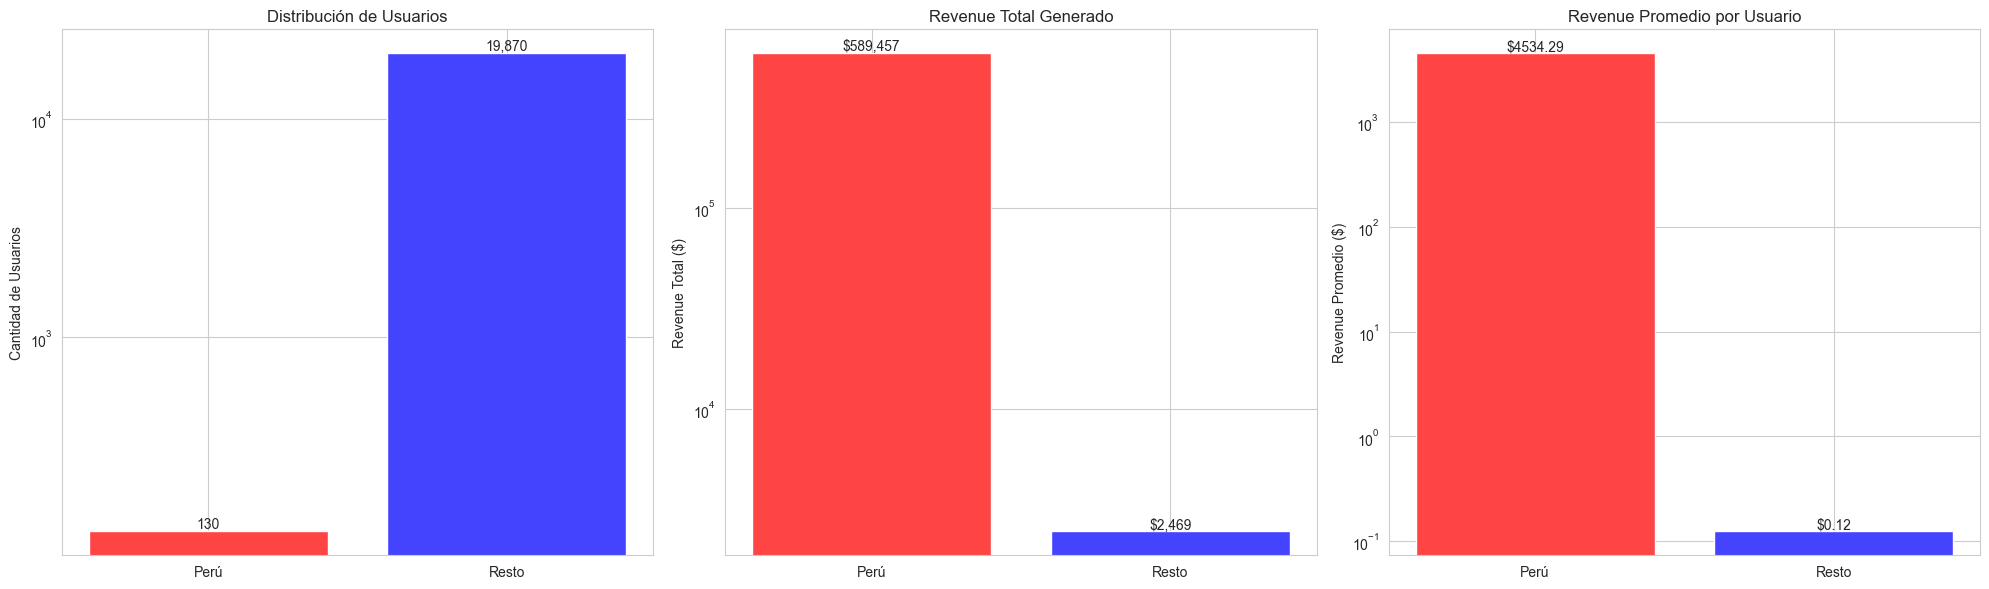


🎯 INSIGHT FINAL

Este dataset muestra un patrón extremadamente inusual:
- El 0.65% de usuarios (Perú) genera el 99.6% del revenue
- Esto sugiere que el juego monetiza exitosamente SOLO en Perú/Lima
- El modelo debe ser capaz de distinguir usuarios peruanos del resto
- La feature 'country_mean_revenue' será crítica para el rendimiento del modelo

¿Posibles explicaciones?
  1. Error en los datos (valores de Perú en otra moneda sin convertir)
  2. El juego es extremadamente popular en el mercado peruano
  3. Diferentes sistemas de pago/monetización por región
  4. Datos de testing/QA desde Perú


In [17]:
pe_users = df[df['country'] == 'pe']
otros_users = df[df['country'] != 'pe']

print('='*80)
print('COMPARACIÓN FINAL: PERÚ VS RESTO DEL MUNDO')
print('='*80)

print(f'\n🇵🇪 PERÚ:')
print(f'  Usuarios:            {len(pe_users):>6,} ({len(pe_users)/len(df)*100:>5.2f}%)')
print(f'  Revenue total:       ${pe_users["revenue"].sum():>12,.2f}')
print(f'  Revenue promedio:    ${pe_users["revenue"].mean():>12,.2f}')
print(f'  Revenue mediana:     ${pe_users["revenue"].median():>12,.2f}')

print(f'\n🌍 RESTO DEL MUNDO (19,870 usuarios de 90 países):')
print(f'  Usuarios:            {len(otros_users):>6,} ({len(otros_users)/len(df)*100:>5.2f}%)')
print(f'  Revenue total:       ${otros_users["revenue"].sum():>12,.2f}')
print(f'  Revenue promedio:    ${otros_users["revenue"].mean():>12,.2f}')
print(f'  Revenue mediana:     ${otros_users["revenue"].median():>12,.2f}')

print(f'\n📈 RATIOS:')
print(f'  Perú genera {pe_users["revenue"].sum() / otros_users["revenue"].sum():.0f}x más revenue total')
print(f'  Usuario peruano promedio genera {pe_users["revenue"].mean() / otros_users["revenue"].mean():.0f}x más revenue')

# Visualización final
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Cantidad de usuarios
axes[0].bar(['Perú', 'Resto'], [len(pe_users), len(otros_users)], color=['#ff4444', '#4444ff'])
axes[0].set_ylabel('Cantidad de Usuarios')
axes[0].set_title('Distribución de Usuarios')
axes[0].set_yscale('log')
for i, (label, val) in enumerate([('Perú', len(pe_users)), ('Resto', len(otros_users))]):
    axes[0].text(i, val, f'{val:,}', ha='center', va='bottom')

# Revenue total
axes[1].bar(['Perú', 'Resto'], [pe_users['revenue'].sum(), otros_users['revenue'].sum()], 
           color=['#ff4444', '#4444ff'])
axes[1].set_ylabel('Revenue Total ($)')
axes[1].set_title('Revenue Total Generado')
axes[1].set_yscale('log')
for i, (label, val) in enumerate([('Perú', pe_users['revenue'].sum()), ('Resto', otros_users['revenue'].sum())]):
    axes[1].text(i, val, f'${val:,.0f}', ha='center', va='bottom')

# Revenue promedio
axes[2].bar(['Perú', 'Resto'], [pe_users['revenue'].mean(), otros_users['revenue'].mean()], 
           color=['#ff4444', '#4444ff'])
axes[2].set_ylabel('Revenue Promedio ($)')
axes[2].set_title('Revenue Promedio por Usuario')
axes[2].set_yscale('log')
for i, (label, val) in enumerate([('Perú', pe_users['revenue'].mean()), ('Resto', otros_users['revenue'].mean())]):
    axes[2].text(i, val, f'${val:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print('\n' + '='*80)
print('🎯 INSIGHT FINAL')
print('='*80)
print('\nEste dataset muestra un patrón extremadamente inusual:')
print('- El 0.65% de usuarios (Perú) genera el 99.6% del revenue')
print('- Esto sugiere que el juego monetiza exitosamente SOLO en Perú/Lima')
print('- El modelo debe ser capaz de distinguir usuarios peruanos del resto')
print('- La feature \'country_mean_revenue\' será crítica para el rendimiento del modelo')
print('\n¿Posibles explicaciones?')
print('  1. Error en los datos (valores de Perú en otra moneda sin convertir)')
print('  2. El juego es extremadamente popular en el mercado peruano')
print('  3. Diferentes sistemas de pago/monetización por región')
print('  4. Datos de testing/QA desde Perú')

## Resumen Ejecutivo

### Hallazgos Clave:

1. **Variables de Eventos:**
   - event_1: Casi irrelevante (corr: -0.001)
   - event_2: La más importante (corr: 0.032)
   - event_3: Moderadamente relevante (corr: 0.006)

2. **Geografía del Revenue:**
   - Perú (130 usuarios, 0.7%) → $589,457 (99.6% del total)
   - Resto del mundo (19,870 usuarios, 99.3%) → $2,469 (0.4%)
   - Lima, Perú concentra el 91.5% del revenue peruano

3. **Usuarios Ballena:**
   - Top 1%: 200 usuarios (77 de Perú, 123 de otros países)
   - Revenue > $100: 74 usuarios (100% de Perú)
   - Las 54 mega-ballenas (>$1K) son TODAS de Perú

4. **Implicaciones para el Modelo:**
   - El modelo debe identificar correctamente usuarios peruanos
   - `country_mean_revenue` será la feature más importante
   - 99.6% del valor de negocio viene de predecir Perú correctamente
   - Para usuarios no-peruanos, el modelo predecirá ~$0

### Recomendaciones:

1. **Validar los datos:** Confirmar que los valores de Perú son correctos
2. **Considerar modelos separados:** Uno para Perú, otro para el resto
3. **Monitorear drift:** Si el patrón de Perú cambia, el modelo colapsaría
4. **Investigar el negocio:** Entender por qué solo Perú monetiza